**Part of PCAR Toolbox for GNU Octave, Matlab, and Python**

*Distributed with the GNU GPLv3 license*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Get data

In [2]:
filename = Path('../../data/Eawag_dataset2.csv')
data   = pd.read_csv(filepath_or_buffer=filename,delimiter  =',',header=0)
X = data.iloc[:,4:54].values
volNO2 = data['NO_2-N stock [mL]'].values
volNO3 = data['NO_3-N stock [mL]'].values
yNO2 = data['mgNO_2-N/L'].values
yNO3 = data['mgNO_3-N/L'].values

print('Input shape:', X.shape)
print('Output(s) shape', yNO3.shape)

Input shape: (256, 50)
Output(s) shape (256,)


# Having a look at the data

Two plots are created:
* One plot with nitrite and nitrate concentrations
* One plot with spectra

In both plots, the blue color indicates data corresponding the highest nitrate concentration. The red color indicate data corresponding to the highest nitrite concentration.

<IPython.core.display.Javascript object>


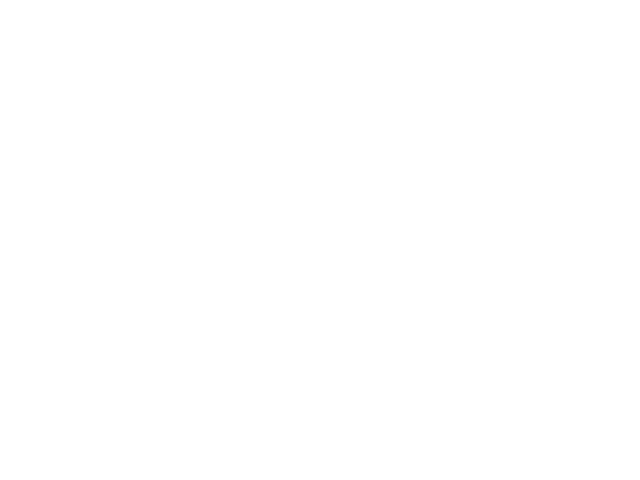

<IPython.core.display.Javascript object>


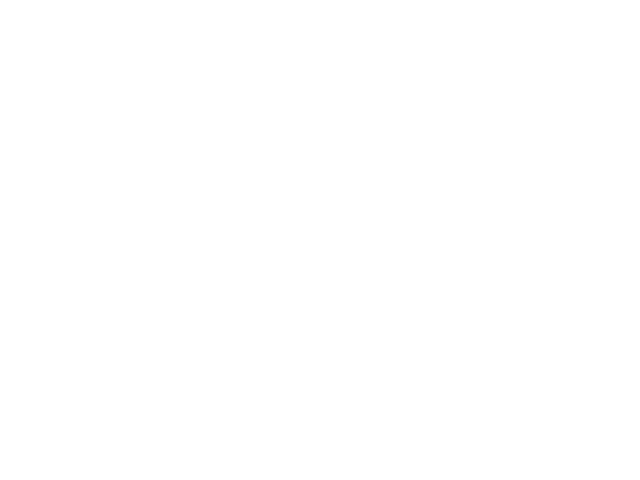

In [3]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(yNO3,yNO2,marker='o',linestyle='none',color='k')

indexmaxNO3 = np.where(yNO3==np.max(yNO3))[0];
ax.plot(yNO3[indexmaxNO3],yNO2[indexmaxNO3],marker='o',linestyle='none',color='c')
indexmaxNO2 = np.where(yNO2==np.max(yNO2))[0];
ax.plot(yNO3[indexmaxNO2],yNO2[indexmaxNO2],marker='o',linestyle='none',color='m');
ax.set_xlabel('$NO3^--N$ lab [mgN/L]')
ax.set_ylabel('$NO2^--N$ lab [mgN/L]')

fig,ax = plt.subplots(1,1)
ax.plot(X.T,color='k');
ax.plot(X[indexmaxNO3,:].T,color='c');
ax.plot(X[indexmaxNO2,:].T,color='m');
ax.set_xlabel('Wavelength index [-]')
ax.set_ylabel('Absorbance [%/m]');
plt.show()

# Split the data into data for calibration/validation and for testing

In [4]:
rCalVal =np.where(np.mod(volNO2+volNO3,4)==0)[0]
rTest =np.where(np.mod(volNO2+volNO3,4)!=0)[0]

<IPython.core.display.Javascript object>


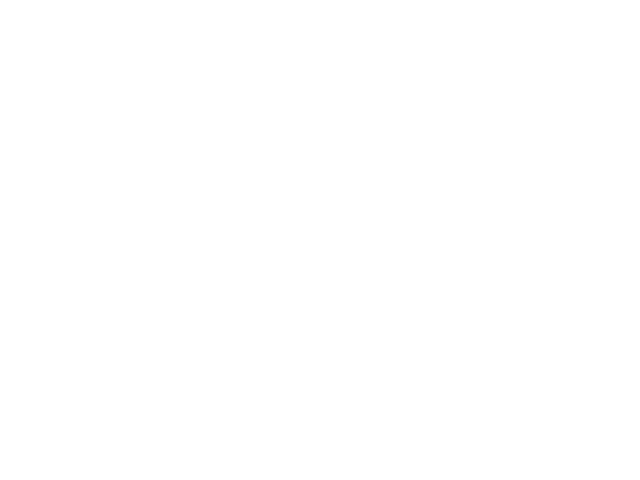

In [5]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(yNO3[rCalVal],yNO2[rCalVal],marker='o',linestyle='none',color='b')
ax.plot(yNO3[rTest],yNO2[rTest],marker='o',linestyle='none',color='r')
ax.set_xlabel('$NO3^--N$ lab [mgN/L]')
ax.set_ylabel('$NO2^--N$ lab [mgN/L]');

# Least absolute shrinkage and selection operator (LASSO)
## LASSO - Building one model

With *sklearn.linear_model.Lasso* one can fit a LASSO model for a single value for the tuning parameter (alpha). With alpha=1, one obtains a sparse model with 6 non-zero coefficients.

In [6]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1,max_iter=10000)
clf.fit(X[rCalVal,:],yNO3[rCalVal])
yNO3hat = clf.predict(X)

<IPython.core.display.Javascript object>


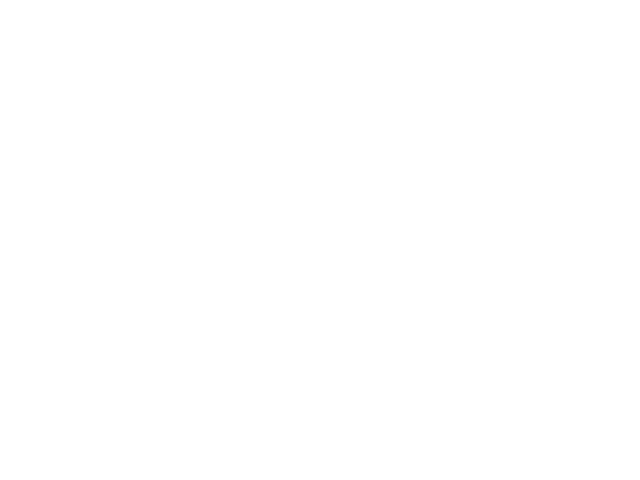

In [7]:
%matplotlib notebook

fig,ax = plt.subplots(2,1)
ax[0].stem(np.arange(50)+1,clf.coef_)
ax[0].set_xlabel('Wavelength index [-]')
ax[0].set_ylabel('Coefficient');
ax[1].plot(yNO3[rCalVal],yNO3hat[rCalVal],marker='.',linestyle='none',color='b');
ax[1].plot(yNO3[rTest],yNO3hat[rTest],marker='.',linestyle='none',color='r');
ax[1].set_xlabel('$NO3^--N$ lab [mgN/L]')
ax[1].set_ylabel('$NO3^--N$ model [mgN/L]')
plt.show()

## LASSO - Path

The LARS path algorithm is available as *sklearn.linear_model* and enables to compute the regression coefficients as a piece-wise linear function of the tuning parameter (alpha). This enables efficient cross-validation procedure as will be shown below. The plot below shows how the coefficients changes with increases of alpha.

In [8]:
from sklearn.linear_model import lars_path
from scipy import interpolate
alphas, active, coef_path_lars = lars_path(X[rCalVal,:],yNO3[rCalVal],method='lasso')
coef_path_continuous = interpolate.interp1d(alphas[::-1],coef_path_lars[:,::-1])

logalphainterp = np.linspace(-6,+3,9*64+1)
alphainterp = 10**logalphainterp
Coeff = coef_path_continuous(alphainterp)

<IPython.core.display.Javascript object>


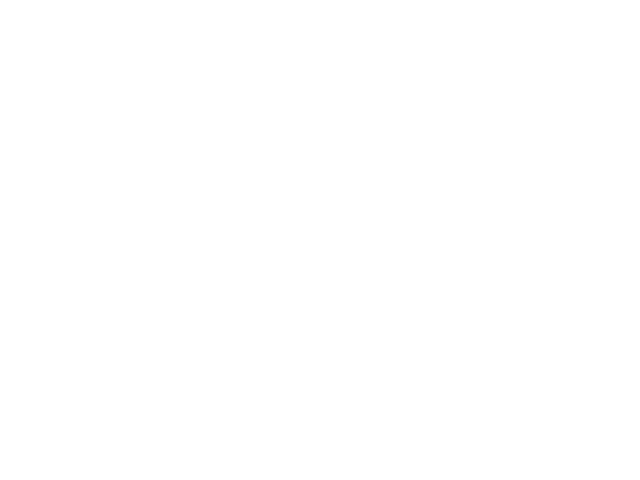

In [9]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(alphainterp ,Coeff.T);
ax.set_xlabel('$alpha$')
ax.set_ylabel('Coefficient')
ax.set_xscale('log')
plt.show()

## LASSO - Leave-One-Out Cross-Validation (LOOCV)

We use leave-one-out cross-validation to determine an optimal value for alpha.

**(!) Note:** In the script below, the for-loop that is required for cross-validation is programmed explicitly for didactic purposes. Note however that *sklearn* includes cross-validation procedures for every regression model. These embedded procedures are usually more efficient.

In [10]:

M = np.shape(rCalVal)[0] 
import warnings
warnings.simplefilter("ignore")

K = len(alphainterp )
Error = np.nan*np.ones([M,K])

for r in range(M):
    rVal = rCalVal[r]
    rCal = np.setdiff1d(rCalVal,rVal)

    alphas, active, coef_path_lars = lars_path(X[rCal,:],yNO3[rCal],method='lasso')
    coef_path_continuous = interpolate.interp1d(alphas[::-1],coef_path_lars[:,::-1])
    
    Coeff = coef_path_continuous(alphainterp)
    yNO3hat = np.dot(X[rVal,:],Coeff)
    Error[r,:] = yNO3hat-yNO3[rVal]
    

## LASSO - Selection with one-standard-deviation rule

The final value of alpha is selected with the one-standard-deviation rule.

In [11]:

MSR = np.sum(Error**2,axis=0)/M
MSRstddev = np.sqrt(np.sum((Error**2-MSR)**2,axis=0)/M)
RMSR = np.sqrt(MSR)
RMSRplusOneStdDev = np.sqrt(MSR+MSRstddev)

RMSRmin =np.min(RMSR)
indexmin = np.where(RMSRmin==RMSR)[-1][-1]
indexselect = np.where(RMSR<=RMSRplusOneStdDev[indexmin])[-1][-1]


print('Minimum cross-validated RMSR:')
print(str(RMSR[indexmin]))
print('Cross-validated RMSR selected model:')
print(str(RMSR[indexselect]))

Minimum cross-validated RMSR:
8.17363062466902
Cross-validated RMSR selected model:
14.887577325586465


<IPython.core.display.Javascript object>


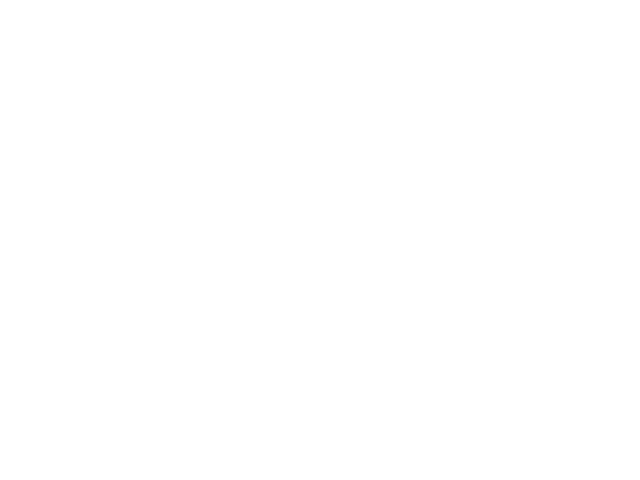

<IPython.core.display.Javascript object>


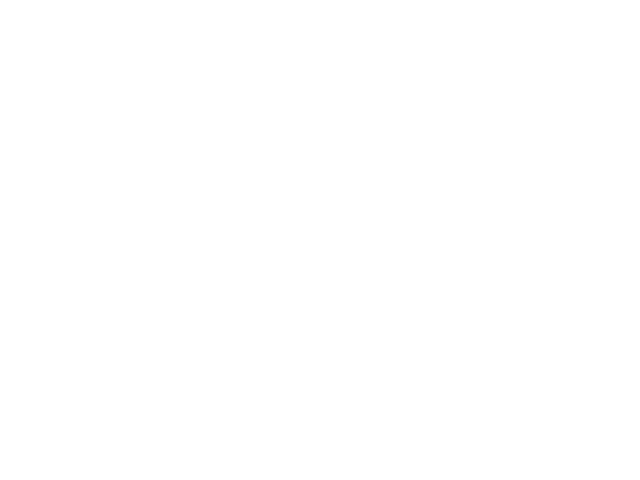

In [12]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
ax.plot(alphainterp ,Coeff.T);
ax.set_xlabel('$alpha$')
ax.set_ylabel('Coefficient')
ax.set_xscale('log')
plt.show()

fig,ax = plt.subplots(1,1)
ax.plot(alphainterp,RMSR,marker='o',linestyle='none',color='k')
ax.plot(alphainterp,RMSRplusOneStdDev,marker='+',linestyle='none',color='k')
ax.plot(alphainterp[indexmin],RMSRmin,marker='o',linestyle='none',color='m',markerfacecolor='none',markersize=11)
ax.plot(alphainterp[indexmin],RMSRplusOneStdDev[indexmin],marker='s',linestyle='none',color='m',markerfacecolor='none',markersize=11)
ax.plot([alphainterp[0],alphainterp[-1]],RMSRplusOneStdDev[indexmin]*np.ones([2,1]),linestyle='--',color='r')

ax.plot(alphainterp[indexselect],RMSR[indexselect],marker='o',linestyle='none',color='b',markerfacecolor='none',markersize=11)

ax.set_xlabel('$alpha$')
ax.set_ylabel('Cross-validated RMSR')
ax.set_xscale('log')
plt.show()

## LASSO - show selected model

We now estimate the parameters with half of the data set and select the set of parameters corresponding to the selected value for alpha. This leads to a model with 3 non-zero coefficients. This model is tested with the other half of the data set to evaluate the out-of-sample prediction quality.

In [13]:
alphas, active, coef_path_lars = lars_path(X[rCalVal,:],yNO3[rCalVal],method='lasso')
coef_path_continuous = interpolate.interp1d(alphas[::-1],coef_path_lars[:,::-1])
Coeff = coef_path_continuous(alphainterp)

yNO3hat = np.dot(X,Coeff[:,indexselect])

<IPython.core.display.Javascript object>


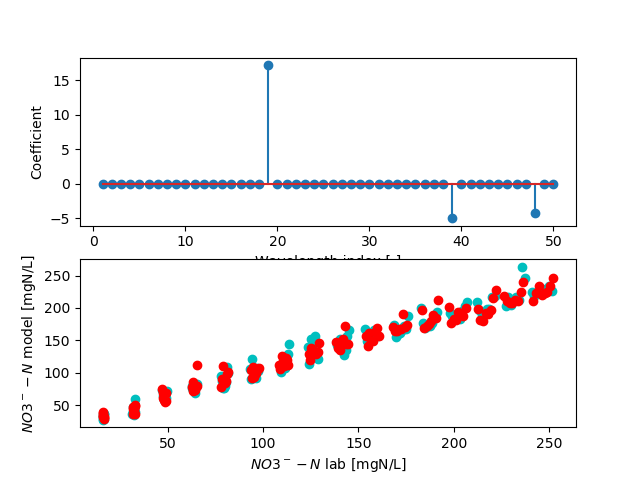

In [14]:
%matplotlib notebook

fig,ax = plt.subplots(2,1)
ax[0].stem(np.arange(50)+1,Coeff[:,indexselect])
ax[0].set_xlabel('Wavelength index [-]');
ax[0].set_ylabel('Coefficient');
ax[1].plot(yNO3[rCalVal],yNO3hat[rCalVal],marker='o',linestyle='none',color='c')
ax[1].plot(yNO3[rTest],yNO3hat[rTest],marker='o',linestyle='none',color='r')
ax[1].set_xlabel('$NO3^--N$ lab [mgN/L]');
ax[1].set_ylabel('$NO3^--N$ model [mgN/L]');
plt.show()